# Logistic regression and MLP (baseline)

## 1. Setup and Imports

In [ ]:
import os
import sys

try:
    base_path = os.path.dirname(__file__)
except NameError:
    base_path = os.getcwd()

# 1️⃣ Ajouter le dossier parent (un cran au-dessus)
parent_dir = os.path.abspath(os.path.join(base_path, '..'))
sys.path.append(parent_dir)

# 2️⃣ Ajouter le dossier parent du dossier parent (deux crans au-dessus)
two_up_dir = os.path.abspath(os.path.join(base_path, '..', '..'))
sys.path.append(two_up_dir)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time

# Import the environment and agents
from permuted_mnist.env.permuted_mnist import PermutedMNISTEnv
from models.Logistic_Regression.logistic_regression import Agent as Logistic_Agent
from models.MLP.mlp_v0 import Agent as torch_mlp_Agent

print("✓ Imports successful")

✓ Imports successful


We fix the seed for reproducibility:

In [3]:
seed = 42

We fix the number of CPUs:

In [4]:
n_jobs = 2

## 2. Create the Environment

Let's create an environment with 10 different permuted tasks:

In [5]:
# Create environment with 10 episodes (tasks)
env = PermutedMNISTEnv(number_episodes=10)

# Set seed for reproducibility
env.set_seed(seed)

print(f"Environment created with {env.number_episodes} permuted tasks")
print(f"Training set size: {env.train_size} samples")
print(f"Test set size: {env.test_size} samples")

Environment created with 10 permuted tasks
Training set size: 60000 samples
Test set size: 10000 samples


## 3. Understanding the Task Structure

Let's examine what a single task looks like:

In [6]:
# Get the first task
task = env.get_next_task()

print("Task structure:")
print(f"- X_train shape: {task['X_train'].shape}")
print(f"- y_train shape: {task['y_train'].shape}")
print(f"- X_test shape: {task['X_test'].shape}")
print(f"- y_test shape: {task['y_test'].shape}")
print(f"\nLabel distribution in training set:")
unique, counts = np.unique(task['y_train'], return_counts=True)
for label, count in zip(unique, counts):
    print(f"  Label {label}: {count} samples")

Task structure:
- X_train shape: (60000, 28, 28)
- y_train shape: (60000, 1)
- X_test shape: (10000, 28, 28)
- y_test shape: (10000,)

Label distribution in training set:
  Label 0: 6131 samples
  Label 1: 6742 samples
  Label 2: 5421 samples
  Label 3: 5851 samples
  Label 4: 6265 samples
  Label 5: 5958 samples
  Label 6: 5949 samples
  Label 7: 5842 samples
  Label 8: 5923 samples
  Label 9: 5918 samples


## 4. Visualize Permuted Images

Let's see how the permutation affects the images:

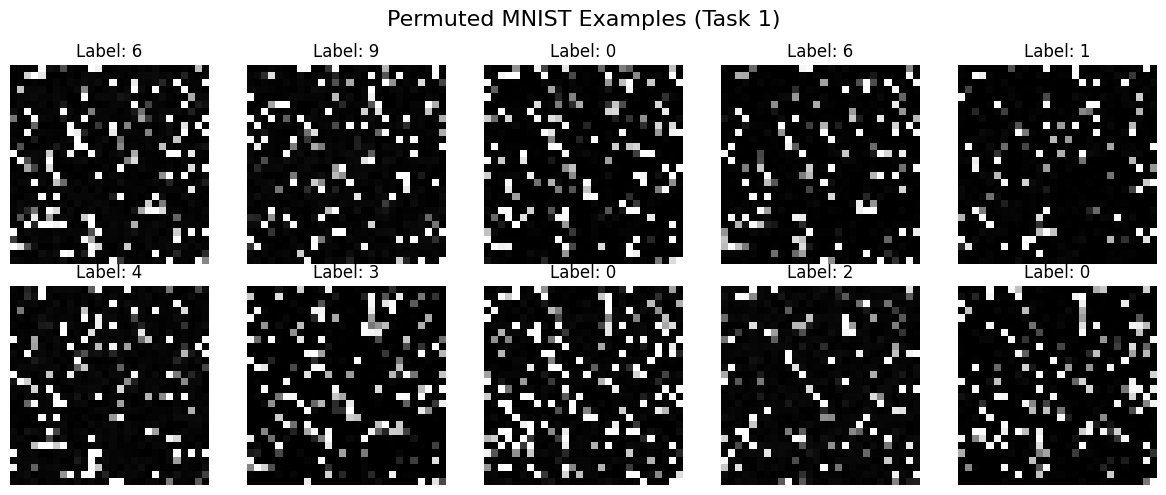

Note: The images look scrambled due to pixel permutation!
The labels are also permuted (not the original MNIST labels).


In [7]:
# Display some examples from the permuted task
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
fig.suptitle('Permuted MNIST Examples (Task 1)', fontsize=16)

for i in range(10):
    ax = axes[i // 5, i % 5]
    ax.imshow(task['X_train'][i], cmap='gray')
    ax.set_title(f'Label: {task["y_train"][i][0]}')
    ax.axis('off')

plt.tight_layout()
plt.show()

print("Note: The images look scrambled due to pixel permutation!")
print("The labels are also permuted (not the original MNIST labels).")

## 5. Logistic regression:

In [8]:
def Logistic_regression(C, max_iter):
    # Reset environment for fresh start
    env.reset()
    env.set_seed(seed)

    # Create logistic regression agent
    logistic_agent = Logistic_Agent(C, max_iter, n_jobs, seed)

    # Track performance
    logistic_regression_accuracies = []
    logistic_regression_times = []

    print(f"Evaluating Logistic regression Agent with max_iter={max_iter} and C={C}:")

    # Evaluate on all tasks
    task_num = 1
    while True:
        task = env.get_next_task()
        if task is None:
            break
        if task_num >= 2: # limited for quick test
            break
            
        # Reset agent for new task
        logistic_agent.reset()
    
        start_time = time.time()
    
        # Train
        logistic_agent.train(task['X_train'], task['y_train'])
    
        # Make predictions
        predictions = logistic_agent.predict(task['X_test'])
    
        # Calculate time and accuracy
        elapsed_time = time.time() - start_time
        accuracy = env.evaluate(predictions, task['y_test'])
    
        logistic_regression_accuracies.append(accuracy)
        logistic_regression_times.append(elapsed_time)
    
        print(f"Task {task_num}: Accuracy = {accuracy:.2%}, Time = {elapsed_time:.4f}s")
        task_num += 1

    mean_accuracy = np.mean(logistic_regression_accuracies)
    std_accuracy = np.std(logistic_regression_accuracies)
    total_time = np.sum(logistic_regression_times)

    print(f"\nLogistic regression Agent Summary:")
    print(f"  Mean accuracy: {mean_accuracy:.2%} ± {std_accuracy:.2%}")
    print(f"  Total time: {total_time:.2f}s")

    return mean_accuracy

In [9]:
perm = np.random.permutation(784)

# Aplatir puis permuter
X_train_flat = task['X_train'].reshape(-1, 784)
X_test_flat  = task['X_test'].reshape(-1, 784)

X_train_perm = X_train_flat[:, perm]
X_train_same = X_train_flat.copy()

agent = Logistic_Agent()

# 1) Entraînement / test sans permutation
agent.train(X_train_same, task['y_train'])
acc1 = np.mean(agent.predict(task['X_test']) == task['y_test'].ravel())  # predict gère le reshape interne

# 2) Entraînement / test avec la même permutation appliquée aux deux sets
agent.reset()
agent.train(X_train_perm, task['y_train'])

# Ici on doit aussi permuter X_test_flat avec la même permutation
X_test_perm = X_test_flat[:, perm]
acc2 = np.mean(agent.predict(X_test_perm) == task['y_test'].ravel())

print("acc without perm:", acc1, "acc with perm:", acc2)

acc without perm: 0.9252 acc with perm: 0.9252


La régression logistique ne dépend pas de l’ordre des pixels, car elle traite chaque pixel comme une variable indépendante, et n’exploite aucune corrélation spatiale. Donc quelle que soit la permutation l'accuracy est la même. Ainsi on peut entrainer le modèle seulement sur une permutation (une task).

In [ ]:
Cs = [0.1]
max_iters = [100]
best_mean_accuracy = 0
best_C = None

for max_iter in max_iters:
    for C in Cs:
        mean_accuracy = Logistic_regression(C, max_iter)
        print('-' * 50)
        if mean_accuracy > best_mean_accuracy:
            best_mean_accuracy = mean_accuracy
            best_C = C
            best_max_iter = max_iter

print(f"The best regularization constant is: {best_C}")
print(f"The best number of iterations is: {best_max_iter}")
print(f"The associated mean accuracy is: {best_mean_accuracy:0.4f}")

Evaluating Logistic regression Agent with max_iter=100 and C=0.1:


## 6. MLP (baseline):

In [ ]:
def MLP():
    # Reset environment for fresh start
    env.reset()
    env.set_seed(seed)

    # Create MLP agent
    mlp_agent = torch_mlp_Agent()

    # Track performance
    mlp_accuracies = []
    mlp_times = []

    print(f"Evaluating MLP Agent:")

    # Evaluate on all tasks
    task_num = 1
    while True:
        task = env.get_next_task()
        if task is None:
            break
        if task_num >= 2: # limited for quick test
            break
            
        # Reset agent for new task
        mlp_agent.reset()
    
        start_time = time.time()
    
        # Train
        mlp_agent.train(task['X_train'], task['y_train'])
    
        # Make predictions
        predictions = mlp_agent.predict(task['X_test'])
    
        # Calculate time and accuracy
        elapsed_time = time.time() - start_time
        accuracy = env.evaluate(predictions, task['y_test'])
    
        mlp_accuracies.append(accuracy)
        mlp_times.append(elapsed_time)
    
        print(f"Task {task_num}: Accuracy = {accuracy:.2%}, Time = {elapsed_time:.4f}s")
        task_num += 1

    mean_accuracy = np.mean(mlp_accuracies)
    std_accuracy = np.std(mlp_accuracies)
    total_time = np.sum(mlp_times)

    print(f"\nMLP Agent Summary:")
    print(f"  Mean accuracy: {mean_accuracy:.2%} ± {std_accuracy:.2%}")
    print(f"  Total time: {total_time:.2f}s")

    return mean_accuracy

In [ ]:
mean_accuracy = MLP()

Evaluating MLP Agent:
epoch 0: 0.9670%
epoch 1: 0.9728%
epoch 2: 0.9761%
epoch 3: 0.9784%
epoch 4: 0.9779%
epoch 5: 0.9788%
epoch 6: 0.9814%
epoch 7: 0.9798%
epoch 8: 0.9808%
epoch 9: 0.9822%
Task 1: Accuracy = 98.20%, Time = 139.3242s

MLP Agent Summary:
  Mean accuracy: 98.20% ± 0.00%
  Total time: 139.32s


Le MLP baseline offre de bonnes performances en prédiction, mais son entraînement est trop long. Nous allons explorer des architectures plus efficaces qui réduisent le temps d’entraînement et de prédiction tout en maintenant un niveau de précision comparable.